In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os

def normalization(data):
    return (data - min(data)) / (max(data) - min(data))

class OneDCNN(nn.Module):
    def __init__(self):
        super(OneDCNN, self).__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(64),
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                    )
        self.conv3 = nn.Sequential(
                        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(256),
                    )
        self.conv4 = nn.Sequential(
                        nn.Conv1d(in_channels=256, out_channels=512, kernel_size=7, padding=3),
                        nn.MaxPool1d(kernel_size=2),
                        nn.ReLU(),
                        nn.BatchNorm1d(512),
                    )


        self.fc1 = nn.Linear(1024//8*256, sample_num)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.to(torch.float32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)

        return x

# 定义数据集
class MyDataset(Dataset):
    def __init__(self, dirs, is_train, test_start = 180):
        self.x = None
        self.y = None
        for data_dir in dirs:
            f_list = os.listdir(data_dir)
            if is_train: 
                for idx in range(min(sample_num, len(f_list))):
                    if self.x is None:
                        self.x = np.load(data_dir + str(idx+1) + '.npy')[:180, :]
                    else:
                        self.x = np.concatenate((self.x, np.load(data_dir + str(idx+1) + '.npy')[:180, :]))
                    tempy = np.zeros((180, sample_num))
                    tempy[:, idx] = 1
                    if self.y is None:
                        self.y = tempy
                    else:
                        self.y = np.concatenate((self.y, tempy))
            else:
                for idx in range(min(sample_num, len(f_list))):
                    if self.x is None:
                        temp = np.load(data_dir + str(idx+1) + '.npy')
                        if temp.shape[0] > 20:
                            self.x = temp[180:200, :]
                        else:
                            self.x = temp
                    else:
                        temp = np.load(data_dir + str(idx+1) + '.npy')
                        if temp.shape[0] > 20:
                            self.x = np.concatenate((self.x, temp[180:200, :]))
                        else:
                            self.x = np.concatenate((self.x, temp))
                    tempy = np.zeros((20, sample_num))
                    tempy[:, idx] = 1
                    if self.y is None:
                        self.y = tempy
                    else:
                        self.y = np.concatenate((self.y, tempy))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

def train(model, dataloader, criterion, optimizer):
    model.train()
    for x, y in dataloader:
        optimizer.zero_grad()
        output = model(x.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        optimizer.step()

def test(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            output = model(x.to(device))
            test_loss += criterion(output, y.to(device)).item()
            pred = output.argmax(dim=1, keepdim=True)
            label = y.argmax(dim=1, keepdim=True)
            correct += pred.cpu().eq(label).sum().item()
    test_loss /= len(dataloader.dataset)
    accuracy = 100.0 * correct / len(dataloader.dataset)
    return test_loss, accuracy

def mean(arr):
    _sum = 0 
    for i in arr:
        _sum += i
    return _sum / len(arr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_trian_data_dir = [
                        'data/clean_npy/', 
                        'data/noisy_npy/', 
                        'data/bg_npy/', 
                        'data/clean_wv/', 
                        'data/noisy_wv/', 
                        'data/bg_wv/'
                     ]

all_test_data_dirs = [
                      [
                       'data/noisy_npy/', 'data/bg_npy/', 
                       'data/DnCNN-noisy_npy-clean_npy-part/', 'data/DnCNN-bg_npy-clean_npy-part/', 'data/DnCNN-new-c-to-n-clean_npy-part/', 
                       'data/DnCNN-new-c-to-bg-clean_npy-part/', 'data/CycleGAN-noisy_npy-clean_npy/', 'data/CycleGAN-bg_npy-clean_npy/', 
                       'data/DnCNN-noisy_npy-clean_npy-part-50/', 'data/DnCNN-bg_npy-clean_npy-part-50/', 'data/DnCNN-new-c-to-n-clean_npy-part-50/', 
                       'data/DnCNN-new-c-to-bg-clean_npy-part-50/', 'data/CycleGAN-noisy_npy-clean_npy-50/', 'data/CycleGAN-bg_npy-clean_npy-50/', 
                       'data/DnCNN-noisy_npy-clean_npy-part-30/', 'data/DnCNN-bg_npy-clean_npy-part-30/', 'data/DnCNN-new-c-to-n-clean_npy-part-30/', 
                       'data/DnCNN-new-c-to-bg-clean_npy-part-30/', 'data/CycleGAN-noisy_npy-clean_npy-30/', 'data/CycleGAN-bg_npy-clean_npy-30/', 
                      ],
                      [
                       'data/clean_npy/', 'data/bg_npy/',
                       'data/DnCNN-clean_npy-noisy_npy-part/', 'data/DnCNN-bg_npy-noisy_npy-part/', 'data/DnCNN-new-n-to-c-noisy_npy-part/', 
                       'data/DnCNN-new-n-to-bg-noisy_npy-part/', 'data/CycleGAN-clean_npy-noisy_npy/', 'data/CycleGAN-bg_npy-noisy_npy/', 
                       'data/DnCNN-clean_npy-noisy_npy-part-50/', 'data/DnCNN-bg_npy-noisy_npy-part-50/', 'data/DnCNN-new-n-to-c-noisy_npy-part-50/', 
                       'data/DnCNN-new-n-to-bg-noisy_npy-part-50/', 'data/CycleGAN-clean_npy-noisy_npy-50/', 'data/CycleGAN-bg_npy-noisy_npy-50/', 
                       'data/DnCNN-clean_npy-noisy_npy-part-30/', 'data/DnCNN-bg_npy-noisy_npy-part-30/', 'data/DnCNN-new-n-to-c-noisy_npy-part-30/', 
                       'data/DnCNN-new-n-to-bg-noisy_npy-part-30/', 'data/CycleGAN-clean_npy-noisy_npy-30/', 'data/CycleGAN-bg_npy-noisy_npy-30/', 
                      ],
                      [
                       'data/clean_npy/', 'data/noisy_npy/', 
                       'data/DnCNN-clean_npy-bg_npy-part/', 'data/DnCNN-noisy_npy-bg_npy-part/', 'data/DnCNN-new-bg-to-c-bg_npy-part/', 
                       'data/DnCNN-new-bg-to-n-bg_npy-part/', 'data/CycleGAN-clean_npy-bg_npy/', 'data/CycleGAN-noisy_npy-bg_npy/', 
                       'data/DnCNN-clean_npy-bg_npy-part-50/', 'data/DnCNN-noisy_npy-bg_npy-part-50/', 'data/DnCNN-new-bg-to-c-bg_npy-part-50/',
                       'data/DnCNN-new-bg-to-n-bg_npy-part-50/', 'data/CycleGAN-clean_npy-bg_npy-50/', 'data/CycleGAN-noisy_npy-bg_npy-50/',
                       'data/DnCNN-clean_npy-bg_npy-part-30/', 'data/DnCNN-noisy_npy-bg_npy-part-30/', 'data/DnCNN-new-bg-to-c-bg_npy-part-30/',
                       'data/DnCNN-new-bg-to-n-bg_npy-part-30/', 'data/CycleGAN-clean_npy-bg_npy-30/', 'data/CycleGAN-noisy_npy-bg_npy-30/',
                      ],
                      [
                       'data/DnCNN-noisy_wv-clean_wv-part/', 'data/DnCNN-bg_wv-clean_wv-part/', 
                       'data/DnCNN-noisy_wv-clean_wv-part-50/', 'data/DnCNN-bg_wv-clean_wv-part-50/', 
                       'data/DnCNN-noisy_wv-clean_wv-part-30/', 'data/DnCNN-bg_wv-clean_wv-part-30/'
                      ],
                      [
                       'data/DnCNN-clean_wv-noisy_wv-part/', 'data/DnCNN-bg_wv-noisy_wv-part/', 
                       'data/DnCNN-clean_wv-noisy_wv-part-50/', 'data/DnCNN-bg_wv-noisy_wv-part-50/', 
                       'data/DnCNN-clean_wv-noisy_wv-part-30/', 'data/DnCNN-bg_wv-noisy_wv-part-30/', 
                      ],
                      [
                       'data/DnCNN-clean_wv-bg_wv-part/', 'data/DnCNN-noisy_wv-bg_wv-part/', 
                       'data/DnCNN-clean_wv-bg_wv-part-50/', 'data/DnCNN-noisy_wv-bg_wv-part-50/', 
                       'data/DnCNN-clean_wv-bg_wv-part-30/', 'data/DnCNN-noisy_wv-bg_wv-part-30/', 
                      ]
                     ]

for trian_data_dir, test_data_dirs in zip(all_trian_data_dir, all_test_data_dirs):
    print('\n')
    sample_num = 10
        
    results = []
    for i in range(len(test_data_dirs)):
        results.append([])

    for sample_times in range(10):
        model = OneDCNN().cuda()
        target_path = "save/{}_1DCNN_{}.pth".format(trian_data_dir.split('/')[1], sample_times)
        if os.path.exists(target_path):
            model.load_state_dict(torch.load(target_path))
            model.eval()
            idx = 0
            for test_data_dir in test_data_dirs:
                test_dataset = MyDataset([test_data_dir], False, 0)
                test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
                test_loss, accuracy = test(model, test_loader, criterion)
                results[idx].append(accuracy)
                idx+=1
            continue
        # print(model)
        optimizer = optim.Adam(model.parameters(), lr=0.00003)
        criterion = nn.CrossEntropyLoss()

        train_dataset = MyDataset([trian_data_dir], True)
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        for epoch in range(160):
            train(model, train_loader, criterion, optimizer)
        idx = 0
        for test_data_dir in test_data_dirs:
            test_dataset = MyDataset([test_data_dir], False, 0)
            test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
            test_loss, accuracy = test(model, test_loader, criterion)
            results[idx].append(accuracy)
            idx+=1
        torch.save(model.state_dict(), "save/{}_1DCNN_{}.pth".format(trian_data_dir.split('/')[1], sample_times))
    for i in range(len(test_data_dirs)):
        print("result of model {}: mean: {}, max: {}, min: {}".format(test_data_dirs[i], mean(results[i]),max(results[i]),min(results[i])))




result of model data/noisy_npy/: mean: 61.5, max: 68.5, min: 57.0
result of model data/bg_npy/: mean: 34.6, max: 39.5, min: 28.5
result of model data/DnCNN-noisy_npy-clean_npy-part/: mean: 75.45, max: 79.5, min: 73.0
result of model data/DnCNN-bg_npy-clean_npy-part/: mean: 66.3, max: 73.5, min: 62.0
result of model data/DnCNN-new-c-to-n-clean_npy-part/: mean: 85.3, max: 89.0, min: 78.0
result of model data/DnCNN-new-c-to-bg-clean_npy-part/: mean: 82.7, max: 87.5, min: 79.0
result of model data/CycleGAN-noisy_npy-clean_npy/: mean: 75.05, max: 82.0, min: 67.5
result of model data/CycleGAN-bg_npy-clean_npy/: mean: 59.6, max: 64.0, min: 54.5
result of model data/DnCNN-noisy_npy-clean_npy-part-50/: mean: 71.5, max: 74.0, min: 69.5
result of model data/DnCNN-bg_npy-clean_npy-part-50/: mean: 55.8, max: 60.5, min: 51.0
result of model data/DnCNN-new-c-to-n-clean_npy-part-50/: mean: 82.6, max: 85.0, min: 80.5
result of model data/DnCNN-new-c-to-bg-clean_npy-part-50/: mean: 73.55, max: 81.0, m

# Process raw data

In [6]:
import os
import numpy as np 
def normalization(data):
    return (data - min(data)) / (max(data) - min(data))
        
for sample_id in range(12,13):
    data_dir = str.format('data/bg_spectrum/{}-supplymental/', sample_id)
    f_list = os.listdir(data_dir)
    final_data = []
    for filename in f_list:
        f = open(data_dir + filename,'r')
        # if len(final_data) != 114:
        flist = []
        # print(filename)
        for line in f.readlines():
            flist.append(int(line.split('\t')[1].strip()))
        for i in range(24):
            flist.append(0)
        arr = np.array(flist)
        final_data.append(normalization(arr))
    # print(normalization(arr))
    final_arr = np.array(final_data)
    print(np.mean(final_data))
    print(np.std(final_data))
    np.save(str.format('data/bg_npy/{}-supplymental', sample_id), final_arr)

0.4206898099864825
0.33711169408416863


# From raw npy data to smooth npy data

In [31]:
import os
import numpy as np 
f_list = os.listdir('data/clean_npy/')
for t_file in f_list:
    data = np.load(str.format('data/clean_npy/{}', t_file))
    for i in range(data.shape[0]):
        data[i] = savgol_filter(data[i], 8, 3, mode= 'nearest')

    np.save(str.format('data/smooth_clean_npy/{}', t_file), data)

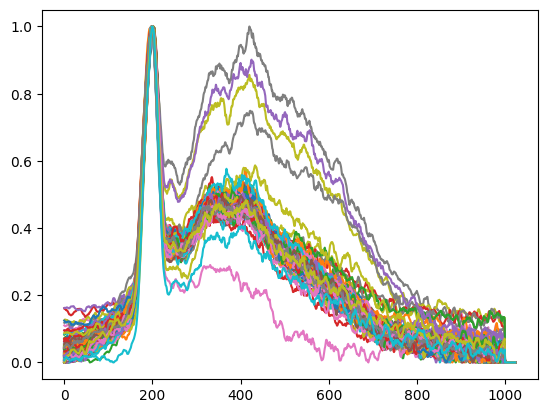

In [42]:
import matplotlib.pyplot as plt
# final_arr = np.load(str.format('data/new-bg-to-n/3.npy'))
final_arr = np.load(str.format('data/noisy_npy/5.npy'))
for i in range(200):
    # plt.cla()
    plt.plot(final_arr[i])
    # plt.savefig(str.format('data/figs/{}.png', i))

In [43]:
import imageio
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for i in range(188):
        image = imageio.imread(str.format('data/figs/{}.png', i))
        writer.append_data(image)

/tmp/ipykernel_625025/696923902.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(str.format('data/figs/{}.png', i))


In [52]:
!pip install tqdm

/bin/bash: /home/visitor/anaconda3/envs/1DCNN/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://mirror.baidu.com/pypi/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.4 MB/s eta 0:00:00


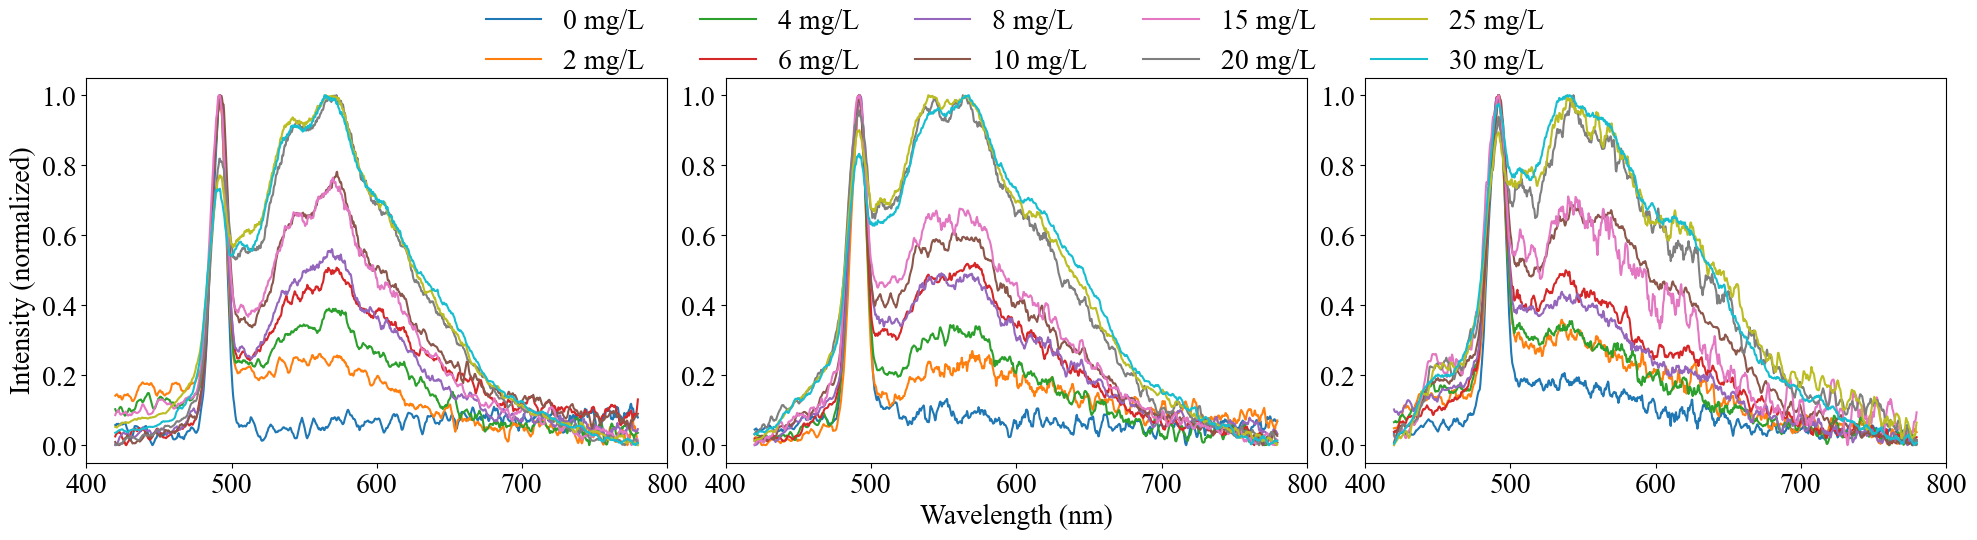

In [43]:
import os
import numpy as np 
import matplotlib.pyplot as plt
# current = "12-supplymental"
# data = np.load("data/bg_npy/"+current+".npy")
plt.rc('font',family='Times New Roman')
plt.rcParams.update({"font.size":20})
labels = ['0 mg/L', '2 mg/L', '4 mg/L', '6 mg/L', '8 mg/L',
          '10 mg/L', '15 mg/L', '20 mg/L', '25 mg/L', '30 mg/L']
fig = plt.figure(figsize=(24,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
current = "9"
for current in range(10):
    data1 = np.load("data/clean_npy/"+str(current+1)+".npy")
    # print(len())
    ax1.set_ylabel('Intensity (normalized)')
    ax1.plot(np.arange(420,780,0.36), data1[1][:1000])
    ax1.set_xlim(400,800)
    data2 = np.load("data/noisy_npy/"+str(current+1)+".npy")
    ax2.plot(np.arange(420,780,0.36), data2[1][:1000])
    # ax2.get_yaxis().set_visible(False)
    ax2.set_xlim(400,800)
    ax2.set_xlabel('Wavelength (nm)')
    data3 = np.load("data/bg_npy/"+str(current+1)+".npy")
    # ax3.get_yaxis().set_visible(False)
    ax3.plot(np.arange(420,780,0.36), data3[1][:1000])
    ax3.set_xlim(400,800)
fig.legend(labels ,loc = (0.24,0.84), ncol=5, frameon=False) #生成legend
plt.savefig('samples_3.png')

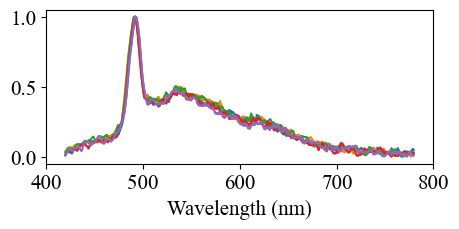

In [39]:
import os
import numpy as np 
import matplotlib.pyplot as plt
idx = "4"
sp = None
# data = np.load("data/new-bg-to-n/"+idx+".npy")
plt.figure(figsize = (5,2))
plt.rc('font',family='Times New Roman')
plt.rcParams.update({"font.size":15})
# data = np.load("data/clean_npy/"+idx+".npy")
# plt.ylabel('Intensity (normalized)')
plt.xlabel('Wavelength (nm)')
plt.xlim(400,800)
data = np.load("data/bg_npy/"+idx+".npy")
for i in range(0,5):
    # if np.average(data[i][380:420]) < 0.08:
    # if np.min(data[i][195:205]) < 0.89:
    # if np.min(data[i][390:410]) < 0.1:
    # if np.max(data[i][250:350]) > 0.4:
        # data[i] = data[i-1]
        plt.plot(np.arange(420,780,0.36), data[i][:1000])
        # print(i)
# data[34] = data[33]

In [228]:
np.save("data/new-bg-to-n/"+idx+".npy", data)